In [1]:
from pysmo.sac import sacio, sacfunc
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
from audio_embed import utilities
import os
from tqdm import tnrange
import random
import h5py
utilities.apply_style()
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [212]:
def load_data(directory):
    earthquakes = []
    earthquake_files = [x for x in os.listdir(directory) if '.SAC' in x]
    progress_bar = tnrange(len(earthquake_files))
    shape = None
    for i in progress_bar:
        earthquake_file = earthquake_files[i]
        progress_bar.set_description(earthquake_file)
        earthquake = sacio.sacfile(os.path.join(directory, earthquake_file))
        t, data = sacfunc.sac2xy(earthquake)
        t = np.array(t)
        data = np.array(data)
        if shape is None:
            shape = data.shape
        if data.shape == shape:
            data = np.vstack([data, t])
            earthquakes.append(data)
    return earthquakes

positive_earthquakes = []
positive_earthquakes += load_data('SAC_20050328_XF/positive/')
positive_earthquakes += load_data('20100227/positive/')
positive_earthquakes += load_data('to_Prem_20050328/SAC_20050328_positive/')
positive_earthquakes += load_data('SAC_20041226_XF/SAC_20041226_XF/positive/')
positive_cutoff = len(positive_earthquakes) - 150
 
negative_earthquakes = []
negative_earthquakes += load_data('SAC_20050328_XF/negative/')
negative_earthquakes += load_data('20100227/negative/')
negative_earthquakes += load_data('to_Prem_20050328/SAC_20050328_negative/')
negative_earthquakes += load_data('SAC_20041226_XF/SAC_20041226_XF/negative/')
negative_cutoff = len(negative_earthquakes) - 150

HBox(children=(IntProgress(value=0, max=95), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=105), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=22), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=220), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=190), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=888), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=36), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=125), HTML(value=u'')))

In [213]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [214]:
#TODO: Whiten across all station data
#TODO: Data augmentation by adding high pass from one station to a low pass of another

def extract_features(data, sr=100.0):
    raw_data = data/np.max(np.abs(data))
    b, a = butter_highpass(5.0, sr, 2)
    high_pass = lfilter(b, a, raw_data)
    
    b, a = butter_bandpass(2.0, 8.0, sr, 2)
    band_pass = lfilter(b, a, raw_data)
    
    b, a = butter_lowpass(2.0, sr, 2)
    low_pass = lfilter(b, a, raw_data)
    
    band_spectrogram = extract_spectrogram(band_pass, 2.0, 8.0)
    high_spectrogram = extract_spectrogram(high_pass, 5.0, 7.0)
    low_spectrogram = extract_spectrogram(low_pass, 0.0, 2.0)
    
    return np.vstack([band_spectrogram, low_spectrogram])[:, :50]
    
def extract_spectrogram(data, low_cutoff, high_cutoff, sr=40):
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=2048, hop_length=2048)), ref=0.0)
    fft_frequencies = librosa.fft_frequencies(sr=sr, n_fft=2048)
    low = (np.abs(fft_frequencies - low_cutoff)).argmin()
    high = (np.abs(fft_frequencies - high_cutoff)).argmin()
    #mel_filters = librosa.filters.mel(100, 2048, n_mels=300)
    #spectrogram = np.dot(mel_filters, spectrogram)
    return spectrogram[low:high, :]

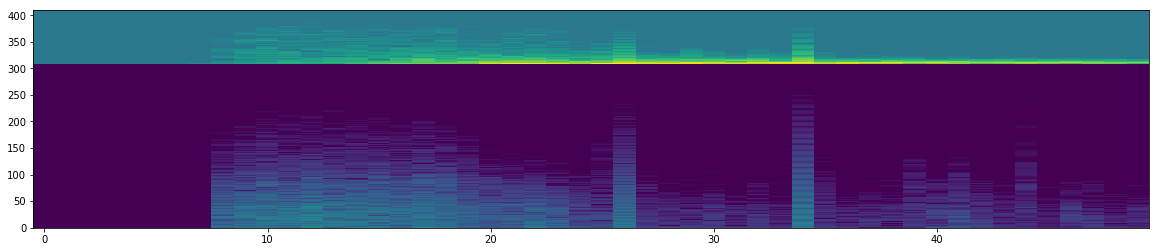

In [215]:
plt.figure(figsize=(20, 4))
plt.imshow(extract_features(positive_earthquakes[-1][0, :]), origin='lower', aspect='auto')
plt.show()

In [216]:
extract_features(negative_earthquakes[0][0, :]).shape

(410, 50)

In [217]:
rm earthquakes.h5

In [218]:
len(positive_earthquakes), len(negative_earthquakes)

(405, 950)

In [219]:
import h5py
shape = (1,) + extract_features(positive_earthquakes[0][0, :]).shape

dataset = h5py.File('earthquakes.h5', 'w')
dataset.create_group('training')
dataset.create_group('testing')

split = 'training'
amount_for_testing = 50

dataset[split].create_dataset('data', 
                                   shape=shape, 
                                   maxshape=(None, None, None)) 
dataset[split].create_dataset('label', 
                                   shape=(1, 1), 
                                   maxshape=(None, None))

for i in tnrange(positive_cutoff):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(positive_earthquakes[i][0, :])
    dataset[split]['label'][current_size - 1] = 1
    dataset[split]['data'].resize(current_size + 1, axis = 0)
    dataset[split]['label'].resize(current_size + 1, axis = 0)
    
for i in tnrange(negative_cutoff):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(negative_earthquakes[i][0, :])
    dataset[split]['label'][current_size - 1] = 0
    if i < (len(negative_earthquakes) - 5) - 1:
        dataset[split]['data'].resize(current_size + 1, axis = 0)
        dataset[split]['label'].resize(current_size + 1, axis = 0)

split = 'testing'

dataset[split].create_dataset('data', 
                                   shape=shape, 
                                   maxshape=(None, None, None)) 
dataset[split].create_dataset('label', 
                                   shape=(1, 1), 
                                   maxshape=(None, None))
for i in tnrange(positive_cutoff, len(positive_earthquakes)):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(positive_earthquakes[i][0, :])
    dataset[split]['label'][current_size - 1] = 1
    dataset[split]['data'].resize(current_size + 1, axis = 0)
    dataset[split]['label'].resize(current_size + 1, axis = 0)
    
for i in tnrange(negative_cutoff, len(negative_earthquakes)):
    current_size = dataset[split]['data'].shape[0]
    dataset[split]['data'][current_size - 1] = extract_features(negative_earthquakes[i][0, :])
    dataset[split]['label'][current_size - 1] = 0
    if i < len(negative_earthquakes) - 1:
        dataset[split]['data'].resize(current_size + 1, axis = 0)
        dataset[split]['label'].resize(current_size + 1, axis = 0)

HBox(children=(IntProgress(value=0, max=255), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=800), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=150), HTML(value=u'')))

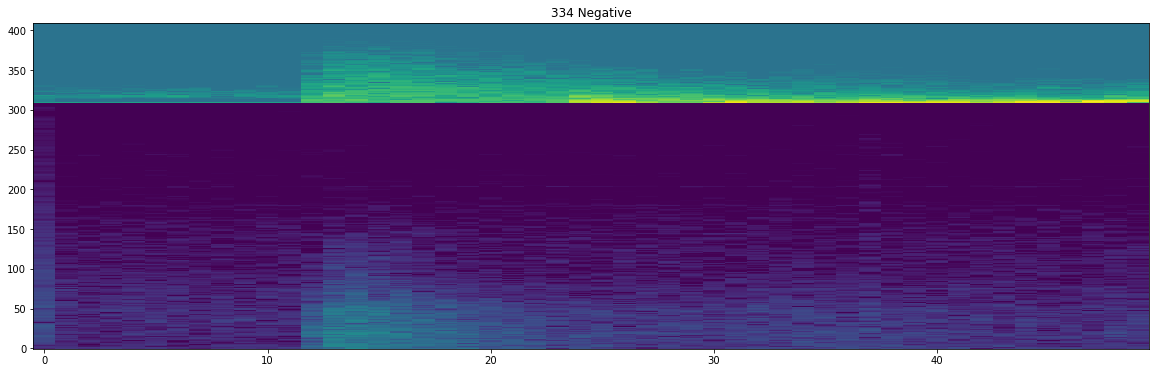

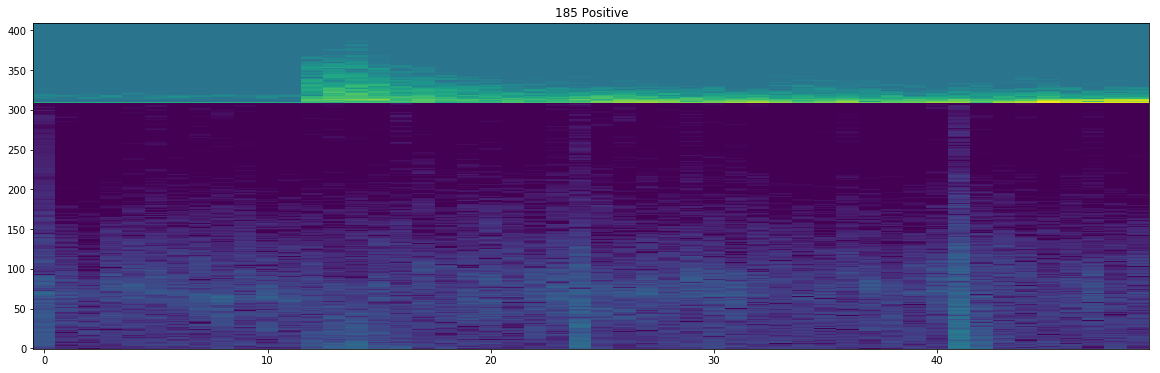

In [245]:
def show_datapoint(i, split):
    mean = np.mean(dataset['training']['data'])
    std = np.std(dataset['training']['data'])
    labels = ['Negative', 'Positive']
    plt.figure(figsize=(20, 6))
    #plt.imshow(dataset[split]['data'][i].T, origin='lower', aspect='auto', cmap='Greys')
    data = dataset[split]['data'][i] - mean
    data /= std
    plt.imshow(data, origin='lower', aspect='auto')
    plt.title(str(i) + ' ' + labels[int(dataset[split]['label'][i][0])])
    plt.show()

show_datapoint(random.choice(range(dataset['training']['data'].shape[0])), 'training')
show_datapoint(random.choice(range(dataset['training']['data'].shape[0])), 'training')

In [12]:
dataset = h5py.File('earthquakes.h5', 'r')

In [290]:
from torch import nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F

def show_model(model):
    print model
    num_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_parameters += np.cumprod(p.size())[-1]
    print 'Number of parameters: %d' % num_parameters
    
def convert_to_tensor(data):
    tensor = torch.FloatTensor(data)
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(410, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=(1, 4)))
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 47, 5))       
        
    def forward_once(self, input_data):
        num_batch = input_data.size(0)
        input_data = input_data.unsqueeze(1)
        output = self.cnn1(input_data)
        output = output.view(num_batch, -1)
        embedding = self.fc1(output)
        #embedding = nn.functional.normalize(embedding, p=2, dim=-1)
        return embedding
    
    def forward(self, input_one, input_two):
        output_one = self.forward_once(input_one)
        output_two = self.forward_once(input_two)
        return output_one, output_two
    
class SiameseNetworkGRU(nn.Module):
    def __init__(self):
        super(SiameseNetworkGRU, self).__init__()
        self.rnn = nn.GRU(input_size=410, num_layers=1, hidden_size=100, dropout=.25, batch_first=True)
        self.linear = nn.Linear(100, 10)
        
    def forward_once(self, input_data):
        num_batch = input_data.size(0)
        input_data = input_data.permute(0, 2, 1)
        output, hidden = self.rnn(input_data)
        hidden = hidden.view(-1, 100)
        embedding = self.linear(output)
        embedding = embedding.view(num_batch, -1)
        #embedding = nn.functional.normalize(embedding, p=2, dim=-1)
        return embedding
    
    def forward(self, input_one, input_two):
        output_one = self.forward_once(input_one)
        output_two = self.forward_once(input_two)
        return output_one, output_two

def whiten(data, mean, std):
    data -= mean
    data /= std + 1e-8
    return data

def collect_data(dataset, indices):
    data = []
    labels = []
    for i in indices:
        data += [dataset['data'][i]]
        labels += [dataset['label'][i]]
    return np.array(data), np.array(labels)

net = SiameseNetwork().cuda()
net.train()
show_model(net)
progress_bar = tnrange(1000)
loss_function = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.0)
mean = np.mean(dataset['training']['data'])
std = np.std(dataset['training']['data'])
batch_size = 256

for i in progress_bar:
    a = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    b = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    
    data_one, label_one = collect_data(dataset['training'], a)
    data_two, label_two = collect_data(dataset['training'], b)
    
    data_one = whiten(data_one, mean, std)
    data_two = whiten(data_two, mean, std)
    
    data_one = Variable(convert_to_tensor(data_one))
    data_two = Variable(convert_to_tensor(data_two))
    
    same_or_different = np.array(label_one != label_two).astype(np.float)
    
    output_one, output_two = net(data_one, data_two)
    optimizer.zero_grad()
    loss = loss_function(output_one, output_two, Variable(convert_to_tensor(same_or_different)))
    if np.isnan(loss.data[0]):
        plt.imshow(data_one.cpu().data.numpy()[0].T, origin='lower', aspect='auto')
        plt.show()

        plt.imshow(data_two.cpu().data.numpy()[0].T, origin='lower', aspect='auto')
        plt.show()
        break
    loss.backward()
    optimizer.step()
    
    progress_bar.set_description(str(loss.data[0]))

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d (1, 16, kernel_size=(410, 1), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (16, 32, kernel_size=(1, 4), stride=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=1504, out_features=5)
  )
)
Number of parameters: 16181


HBox(children=(IntProgress(value=0, max=1000), HTML(value=u'')))

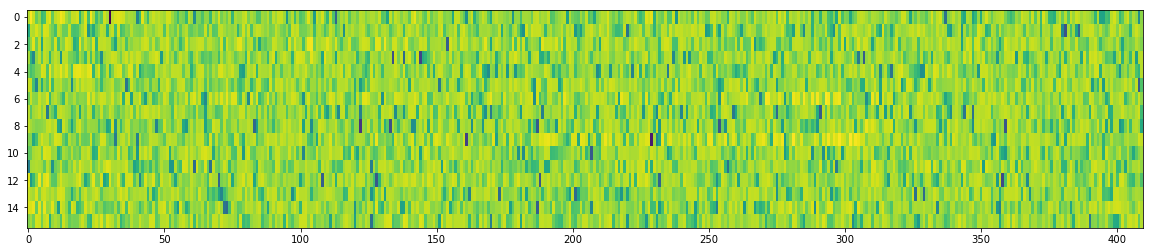

torch.Size([32, 16, 1, 4])


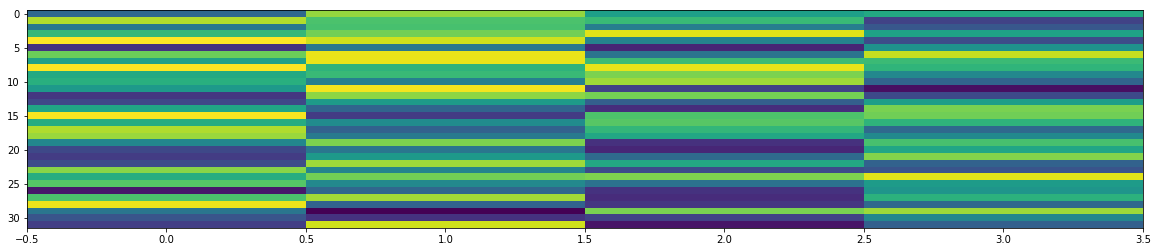

In [295]:
plt.figure(figsize=(20, 4))
plt.imshow(np.log(np.abs(net.cnn1[0].weight[:, 0, :, 0].cpu().data.numpy()) + 1e-7), aspect='auto')
plt.show()
print net.cnn1[2].weight.shape
plt.figure(figsize=(20, 4))
plt.imshow(net.cnn1[2].weight[:, 0, 0, :].cpu().data.numpy(), aspect='auto')
plt.show()

In [292]:
#net_random = SiameseNetwork().cuda()
#net_random.eval()
progress_bar = tnrange(100)
batch_size = 16
test_loss = []
for i in progress_bar:
    a = np.random.choice(range(dataset['testing']['data'].shape[0]), (batch_size,))
    b = np.random.choice(range(dataset['testing']['data'].shape[0]), (batch_size,))
    
    data_one, label_one = collect_data(dataset['testing'], a)
    data_two, label_two = collect_data(dataset['testing'], b)
    
    data_one = whiten(data_one, mean, std)
    data_two = whiten(data_two, mean, std)
    
    data_one = Variable(convert_to_tensor(data_one))
    data_two = Variable(convert_to_tensor(data_two))
    
    same_or_different = np.array(label_one != label_two).astype(np.float)
    
    output_one, output_two = net(data_one, data_two)
    optimizer.zero_grad()
    loss = loss_function(output_one, output_two, Variable(convert_to_tensor(same_or_different)))
    progress_bar.set_description(str(loss.data[0]))
    test_loss.append(loss.data[0])
    
print np.mean(test_loss)

HBox(children=(IntProgress(value=0), HTML(value=u'')))


1.2878026163578034


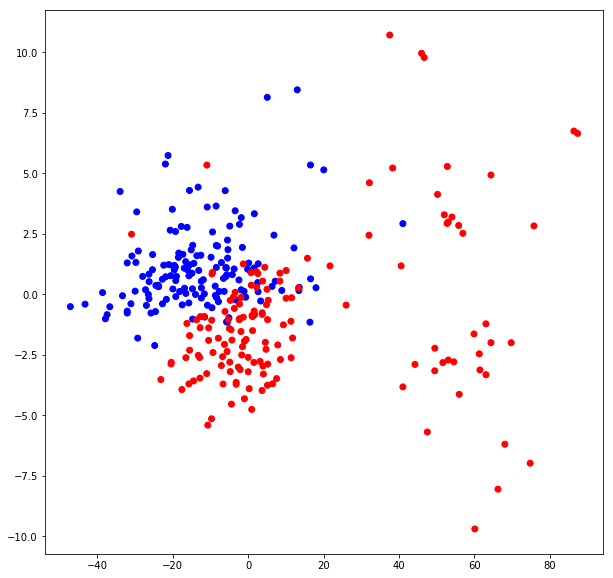

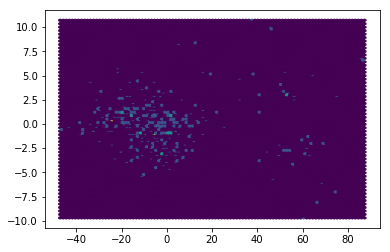

In [297]:
test_embeddings = []
outputs = []
labels = []
guesses = []
split = 'testing'
net.eval()
for i in range(dataset[split]['data'].shape[0]):
    data = Variable(convert_to_tensor(dataset[split]['data'][i])).unsqueeze(0)
    label = dataset[split]['label'][i]
    labels.append(label)
    output = net.forward_once(data)
    #guess = net_classifier(output)
    output = output.squeeze(0).data.cpu().numpy()
    #guesses.append(np.round(guess.squeeze(0).data.cpu().numpy()))
    outputs.append(output)

output = np.array(outputs)

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#transform = TSNE(n_components=2)
transform = PCA(n_components=2)

output_transform = transform.fit_transform(output)
c = ['red', 'blue']
colors = [c[int(l[0])] for l in labels]

plt.figure(figsize=(10,10))
plt.scatter(output_transform[:, 0], output_transform[:, 1], color=colors)
#plt.xlim([-.00025, .00025])
#plt.ylim([-.00025, .00025])
plt.show()

plt.hexbin(output_transform[:, 0], output_transform[:, 1])
#plt.xlim([-.00025, .00025])
#plt.ylim([-.00025, .00025])
plt.show()

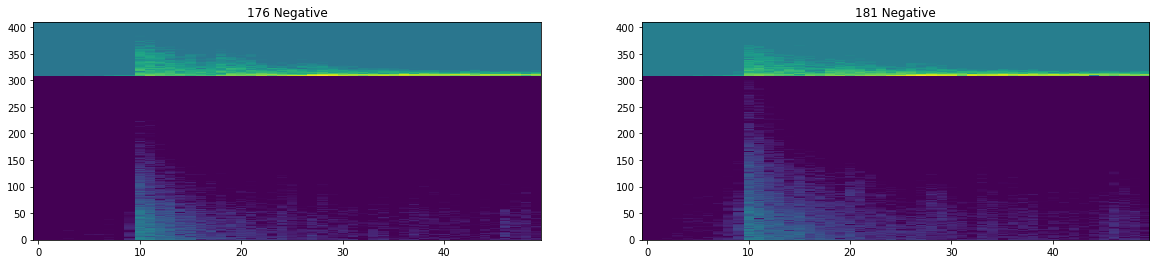

0.0 Variable containing:
-2.9636  2.5445  2.0057 -2.5837 -6.4234
[torch.cuda.FloatTensor of size 1x5 (GPU 0)]
 Variable containing:
-3.7098  1.0787  4.0778  0.3640 -4.5450
[torch.cuda.FloatTensor of size 1x5 (GPU 0)]



In [276]:
def show_siamese(i, j, split):
    labels = ['Negative', 'Positive']
    plt.figure(figsize=(20, 4))
    plt.subplot(121)
    plt.imshow(dataset[split]['data'][i], origin='lower', aspect='auto')
    plt.title(str(i) + ' ' + labels[int(dataset[split]['label'][i][0])])
    plt.subplot(122)
    plt.imshow(dataset[split]['data'][j], origin='lower', aspect='auto')
    plt.title(str(j) + ' ' + labels[int(dataset[split]['label'][j][0])])
    plt.show()
    
    data_one = Variable(convert_to_tensor(dataset[split]['data'][i]).unsqueeze(0))
    data_two = Variable(convert_to_tensor(dataset[split]['data'][j]).unsqueeze(0))
    output_one, output_two = net(data_one, data_two)
    same_or_different =  int(dataset[split]['label'][j][0]) == int(dataset[split]['label'][i][0]) 
    loss = loss_function(output_one, output_two, same_or_different)
    print loss.data[0], output_one, output_two
    #print net_classifier(net.forward_once(data_one)), net_classifier(net.forward_once(data_two))
net.eval()
show_siamese(random.choice(range(dataset['testing']['data'].shape[0])),
             random.choice(range(dataset['testing']['data'].shape[0])),
             'testing')

In [ ]:
class TriggerClassifier(nn.Module):
    def __init__(self):
        super(TriggerClassifier, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(inplace=True),
            nn.Linear(20, 1),
            nn.Sigmoid())
        
    def forward(self, input_data):
        return self.fc1(input_data)

net_classifier = TriggerClassifier().cuda()
net_classifier.train()
net.eval()
show_model(net_classifier)
progress_bar = tnrange(100)
loss_function_ = nn.MSELoss()
optimizer = torch.optim.Adam(net_classifier.parameters(), lr=1e-2, weight_decay=0.0)
mean = np.mean(dataset['training']['data'])
std = np.std(dataset['training']['data'])
batch_size = 16

for i in progress_bar:
    a = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    
    data, label = collect_data(dataset['training'], a)
    data = whiten(data, mean, std)
    
    data = Variable(convert_to_tensor(data))
        
    features = net.forward_once(data)
    output = net_classifier(features)
    
    optimizer.zero_grad()
    loss = loss_function_(output, Variable(convert_to_tensor(label)))
    if np.isnan(loss.data[0]):
        plt.imshow(data_one.cpu().data.numpy()[0].T, origin='lower', aspect='auto')
        plt.show()

        plt.imshow(data_two.cpu().data.numpy()[0].T, origin='lower', aspect='auto')
        plt.show()
        break
    loss.backward()
    optimizer.step()
    
    progress_bar.set_description(str(loss.data[0]))
    


Positive: trigger earthquake in data


/usr/local/lib/python2.7/dist-packages/librosa/display.py:634: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


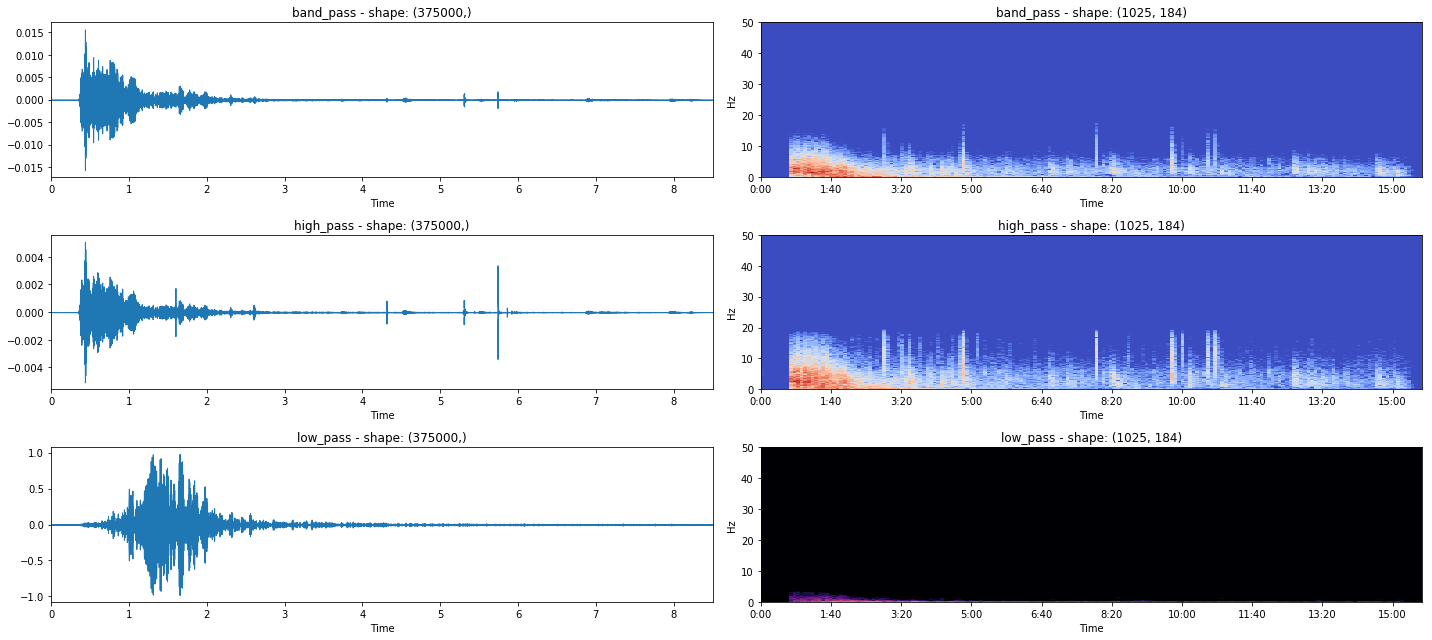

Negative: trigger earthquake NOT in data


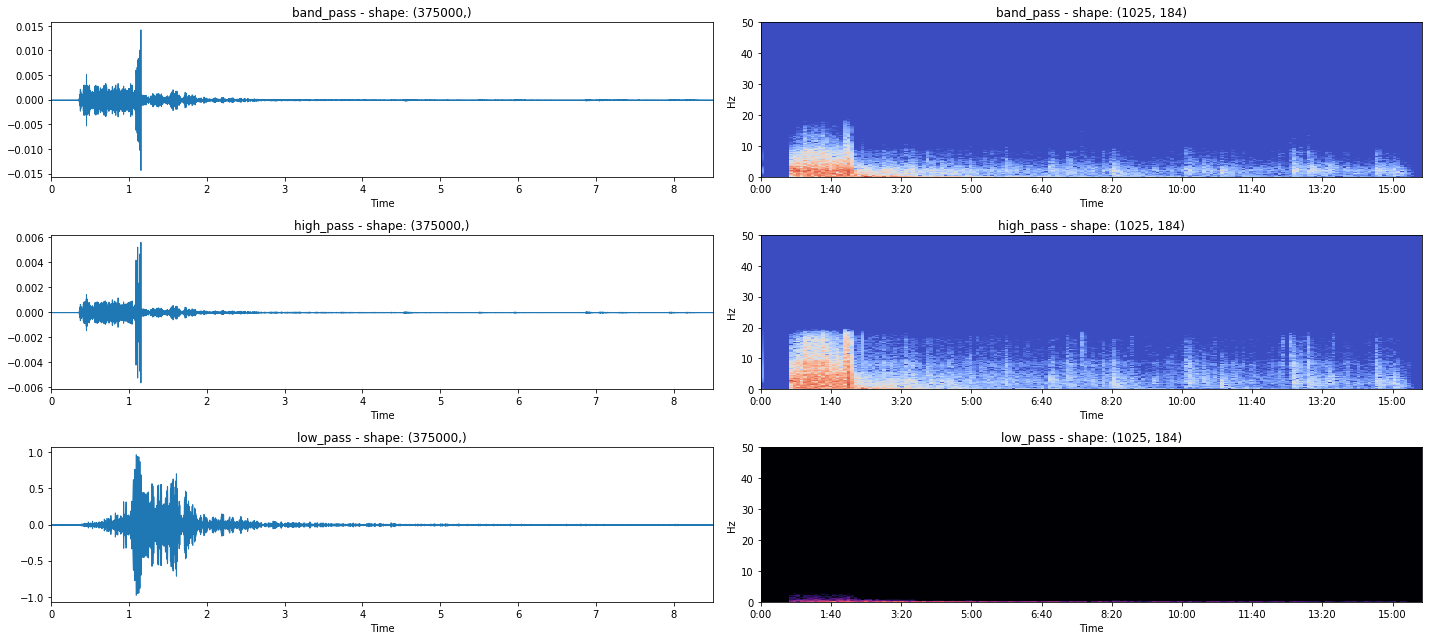

In [11]:
from matplotlib.gridspec import GridSpec

def plot_example(data):
    raw_data = data/np.max(np.abs(data))
    b, a = butter_highpass(5.0, 100.0, 2)
    high_pass = lfilter(b, a, raw_data)
    
    b, a = butter_bandpass(2.0, 8.0, 100, 2)
    band_pass = lfilter(b, a, raw_data)
    
    b, a = butter_lowpass(2.0, 100, 2)
    low_pass = lfilter(b, a, raw_data)
    
    grid = GridSpec(3, 2)    
    
    plt.figure(figsize=(20, 9))
    plot_earthquake(band_pass, grid, 0, 'band_pass')
    plot_earthquake(high_pass, grid, 1, 'high_pass')
    plot_earthquake(low_pass, grid, 2, 'low_pass')
    plt.tight_layout()
    plt.show()
    
def plot_earthquake(data, g, i, text):
    #utilities.audio(data, 400*100)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(data, n_fft=2048, hop_length=2048)), ref=0.0)
    #mel_filters = librosa.filters.mel(100, 2048, n_mels=300)
    #spectrogram = np.dot(mel_filters, spectrogram)
    spectrogram -= np.mean(spectrogram)
    spectrogram /= np.std(spectrogram) + 1e-7
    #spectrogram = (spectrogram.T - np.mean(spectrogram, axis=1)).T
    #spectrogram = (spectrogram.T / (np.std(spectrogram, axis=1) + 1e-7)).T
    plt.subplot(g[i, 0])
    librosa.display.waveplot(data, sr=44100)
    plt.title(text + ' - shape: ' + str(data.shape))
    plt.subplot(g[i, 1])
    librosa.display.specshow(spectrogram, sr=100, x_axis='time', y_axis='linear')
    plt.title(text + ' - shape: ' + str(spectrogram.shape))
    
def plot_random_pair(data_one, data_two):
    example_one = random.choice(data_one)[0, :]
    example_two = random.choice(data_two)[0, :]
    print 'Positive: trigger earthquake in data'
    plot_example(example_one)
    print 'Negative: trigger earthquake NOT in data'
    plot_example(example_two)
    
plot_random_pair(positive_earthquakes, negative_earthquakes)

In [261]:
from torch import nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

def show_model(model):
    print model
    num_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_parameters += np.cumprod(p.size())[-1]
    print 'Number of parameters: %d' % num_parameters
    
def convert_to_tensor(data):
    tensor = torch.FloatTensor(data)
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=(410, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(4, 4, kernel_size=(1, 50)))
        self.fc1 = nn.Sequential(
            nn.Linear(4, 2),
            nn.Softmax())       
        
    def forward(self, input_data):
        num_batch = input_data.size(0)
        input_data = input_data.unsqueeze(1)
        output = self.cnn1(input_data)
        output = output.view(num_batch, -1)
        output = self.fc1(output)
        return output
    
def whiten(data, mean, std):
    data -= mean
    data /= std + 1e-8
    return data

def collect_data(dataset, indices):
    data = []
    labels = []
    for i in indices:
        data += [dataset['data'][i]]
        labels += [dataset['label'][i]]
    return np.array(data), np.array(labels)

net = Classifier().cuda()
net.train()
show_model(net)
progress_bar = tnrange(1000)
loss_function = CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.0)
mean = np.mean(dataset['training']['data'])
std = np.std(dataset['training']['data'])
batch_size = 16

for i in progress_bar:
    a = np.random.choice(range(dataset['training']['data'].shape[0]), (batch_size,))
    
    data_one, label_one = collect_data(dataset['training'], a)
    
    data_one = whiten(data_one, mean, std)
    
    data_one = Variable(convert_to_tensor(data_one))
    label_one = Variable(convert_to_tensor(label_one)).long()
    print label_one
        
    output_one = net(data_one)
    print output_one
    optimizer.zero_grad()
    loss = loss_function(output_one, label_one)
    loss.backward()
    optimizer.step()
    
    progress_bar.set_description(str(loss.data[0]))

Classifier(
  (cnn1): Sequential(
    (0): Conv2d (1, 4, kernel_size=(410, 1), stride=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (4, 4, kernel_size=(1, 50), stride=(1, 1))
  )
  (fc1): Sequential(
    (0): Linear(in_features=4, out_features=2)
    (1): Softmax()
  )
)
Number of parameters: 2458


HBox(children=(IntProgress(value=0, max=1000), HTML(value=u'')))

Variable containing:
    1
    0
    1
    0
    1
    0
    0
    0
    0
    0
    1
    0
    0
    0
    0
    0
[torch.cuda.LongTensor of size 16x1 (GPU 0)]

Variable containing:
 0.3911  0.6089
 0.3767  0.6233
 0.3678  0.6322
 0.4073  0.5927
 0.3989  0.6011
 0.3948  0.6052
 0.3961  0.6039
 0.4596  0.5404
 0.3901  0.6099
 0.4068  0.5932
 0.3451  0.6549
 0.3915  0.6085
 0.3959  0.6041
 0.3812  0.6188
 0.3874  0.6126
 0.4325  0.5675
[torch.cuda.FloatTensor of size 16x2 (GPU 0)]



RuntimeError: multi-target not supported at /pytorch/torch/lib/THCUNN/generic/ClassNLLCriterion.cu:16